In [1]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from dataloader import GeneticDataloaders, SynGeneticDataset, GeneticDataloaders1k
from torch.utils.data import DataLoader
from config import *
import numpy as np
import sklearn
num_samples = 200

import torch




/home/philipkenneweg/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/philipkenneweg/Documents/GeneDiffusion/config.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend y

In [2]:
def draw_samples(dataloader,num_samples):
    data = []
    data_labels = []
    for i, (x, y) in enumerate(dataloader):
        for d in x:
            data.append(d)
        for l in y:
            data_labels.append(l)
        if len(data) >= num_samples:
            break

    data = torch.stack(data)
    data_labels = torch.stack(data_labels)

    out_label = np.argmax(data_labels.numpy(), axis = 1) if len(data_labels.shape) > 1 else data_labels.numpy()
    return data.numpy()[:num_samples], out_label[:num_samples]

In [3]:



datas = []

geneticData = SynGeneticDataset("finalruns/Transformer/")
syn_dataloader = DataLoader(geneticData, batch_size=config["batch_size"])
syn_data, syn_data_labels = draw_samples(syn_dataloader, num_samples)
datas.append(syn_data)

geneticData = SynGeneticDataset("finalruns/UnetMLP/")
syn_dataloader = DataLoader(geneticData, batch_size=config["batch_size"])
syn_data, syn_data_labels = draw_samples(syn_dataloader, num_samples)
datas.append(syn_data)

geneticData = SynGeneticDataset("finalruns/Unet/")
syn_dataloader = DataLoader(geneticData, batch_size=config["batch_size"])
syn_data, syn_data_labels = draw_samples(syn_dataloader, num_samples)
datas.append(syn_data)

# geneticData = SynGeneticDataset("finalruns/Baseline/")
# syn_dataloader = DataLoader(geneticData, batch_size=config["batch_size"])
# syn_data, syn_data_labels = draw_samples(syn_dataloader, num_samples)
# datas.append(syn_data)

geneticData = SynGeneticDataset("finalruns/UnetCombined/")
syn_dataloader = DataLoader(geneticData, batch_size=config["batch_size"])
syn_data, syn_data_labels = draw_samples(syn_dataloader, num_samples)
datas.append(syn_data)

# geneticData = SynGeneticDataset("newgeneration/")
# syn_dataloader = DataLoader(geneticData, batch_size=config["batch_size"])
# syn_data, syn_data_labels = draw_samples(syn_dataloader, num_samples)
# datas.append(syn_data)

#train_dataset = GeneticDataset1k(train = True)
#test_dataset = GeneticDataset1k(train = False)
train_dataloader,test_dataloader = GeneticDataloaders(config["batch_size"]) 
syn_data, syn_data_labels = draw_samples(train_dataloader, num_samples)
datas.append(syn_data)
syn_data, syn_data_labels = draw_samples(test_dataloader, num_samples)
datas.append(syn_data)






/home/philipkenneweg/Documents/GeneDiffusion/dataloader.py:244: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  genome, label = torch.load(self.all_file_paths[idx])


path of dataset finalruns/Transformer/
len of syn dataset 10400
path of dataset finalruns/UnetMLP/
len of syn dataset 10400
path of dataset finalruns/Unet/
len of syn dataset 10400
path of dataset finalruns/UnetCombined/
len of syn dataset 10400
len of dataset 9365
len of dataset 1040


In [4]:
# datasfull =[]
# num_samplesfull = 9000

# train_dataloader,test_dataloader = GeneticDataloaders(config["batch_size"], True) 
# syn_data, syn_data_labels = draw_samples(train_dataloader, num_samplesfull)
# datasfull.append(syn_data)

# geneticData = SynGeneticDataset("finalruns/UnetCombined/")
# syn_dataloader = DataLoader(geneticData, batch_size=config["batch_size"])
# syn_data, syn_data_labels = draw_samples(syn_dataloader, num_samplesfull)
# datasfull.append(syn_data)

In [5]:

combined_data = np.concatenate(datas, axis=0)
combined_data = combined_data.reshape(combined_data.shape[0], -1)
print(combined_data.shape)


combined_labels = np.concatenate([np.zeros(len(datas[i]))+i for i in range(len(datas))])



(1200, 147456)


Embedd the data samples with different models:

In [11]:
from config import *

model = torch.load("finalruns/UnetMLP/model.pt")


model.eval()
current_t = torch.tensor([max_steps-1] , device=device)
y = torch.tensor([num_classes] , device=device)
embeddings = []
with torch.no_grad():
    for data in combined_data:
        
        data = torch.tensor(data).to(device)
        data = data.unsqueeze(0)
        data = data.reshape(1,8,18432)
        # print(data.shape)
        # print(current_t.shape)
        # print(y.shape)
        #pred_eps = model(data, current_t, y = y)
        output, bottleneck = model(data,t = current_t,y = y, output_bottleneck = True)
        embeddings.append(bottleneck.squeeze().cpu().detach().numpy())

embeddings = np.array(embeddings)
print(embeddings.shape)

/tmp/ipykernel_9917/3772930196.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("finalruns/UnetMLP/model.pt")


(1200, 256)


In [19]:
print("computing UMAP for embeddings")
reducer = umap.UMAP(metric = 'euclidean', n_neighbors=5)
embedding = reducer.fit_transform(embeddings)



computing UMAP for embeddings


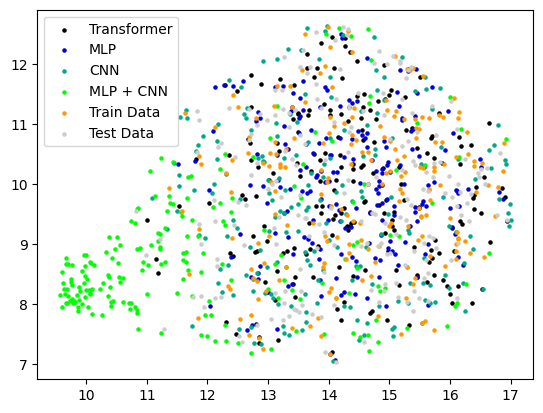

In [20]:
colors = plt.get_cmap('nipy_spectral')(np.linspace(0, 1, len(datas)))
labels =  ["Transformer", "MLP", "CNN", "MLP + CNN" ,"Train Data", "Test Data", ]

for i in range(len(datas)):
    plt_data = embedding[i*num_samples: (i+1)*num_samples]
    plt.scatter(plt_data[:, 0], plt_data[:, 1], color = colors[i], label = labels[i], s = 5)
plt.legend()
plt.savefig("umap_euclidean.png")
plt.show()

In [36]:
model = torch.load("finalruns/Unet/model.pt")

model.eval()
current_t = torch.tensor([max_steps-1] , device=device)
y = torch.tensor([num_classes] , device=device)
embeddingscnn = []
with torch.no_grad():
    for data in combined_data:
        
        data = torch.tensor(data).to(device)
        data = data.unsqueeze(0)
        data = data.reshape(1,8,18432)
        # print(data.shape)
        # print(current_t.shape)
        # print(y.shape)
        #pred_eps = model(data, current_t, y = y)
        output, bottleneck = model(data,current_t,y = y, output_bottleneck = True)
        #print(bottleneck.shape)
        bottleneck = torch.mean(bottleneck, dim = 2)
        embeddingscnn.append(bottleneck.squeeze().cpu().detach().numpy())

embeddingscnn = np.array(embeddingscnn)
print(embeddingscnn.shape)

/tmp/ipykernel_9917/1309471156.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("finalruns/Unet/model.pt")


(1200, 256)


In [37]:
print("computing UMAP for embeddings")
reducer = umap.UMAP(metric = 'euclidean', n_neighbors=15)
embedding = reducer.fit_transform(embeddingscnn)


computing UMAP for embeddings


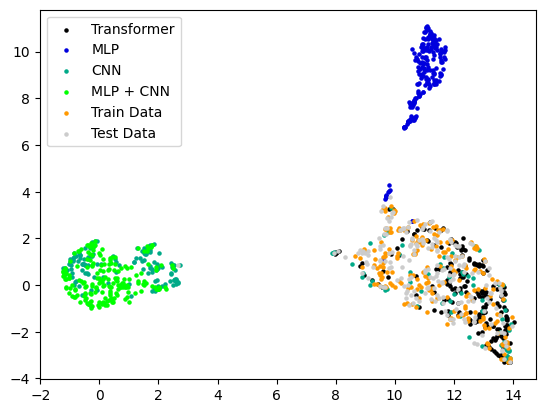

In [38]:
colors = plt.get_cmap('nipy_spectral')(np.linspace(0, 1, len(datas)))
labels =  ["Transformer", "MLP", "CNN", "MLP + CNN" ,"Train Data", "Test Data", ]

for i in range(len(datas)):
    plt_data = embedding[i*num_samples: (i+1)*num_samples]
    plt.scatter(plt_data[:, 0], plt_data[:, 1], color = colors[i], label = labels[i], s = 5)
plt.legend()
plt.savefig("umap_euclidean.png")
plt.show()

In [8]:
print("computing UMAP")
reducer = umap.UMAP(metric = 'cosine', n_neighbors=15)
embedding = reducer.fit_transform(combined_data)

computing UMAP


KeyboardInterrupt: 

In [ ]:
print("computing UMAP")
reducer = umap.UMAP(metric = 'cosine', n_neighbors=15)
embedding2 = reducer.fit_transform(combined_data)

computing UMAP


In [ ]:
print("computing UMAP")
reducer = umap.UMAP(metric = 'euclidean', n_neighbors=15)
embedding3 = reducer.fit_transform(combined_data)

computing UMAP


In [ ]:
print("computing UMAP")
reducer = umap.UMAP(metric = 'euclidean', n_neighbors=5)
embedding4 = reducer.fit_transform(combined_data)

computing UMAP


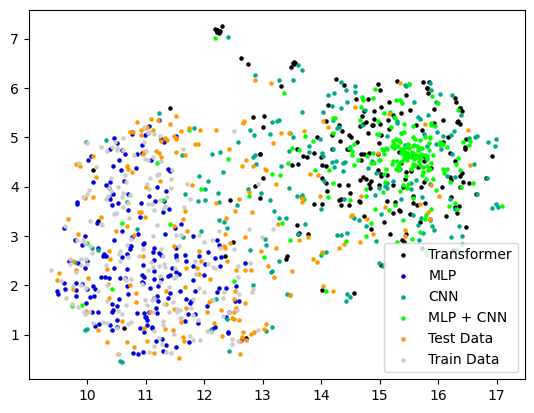

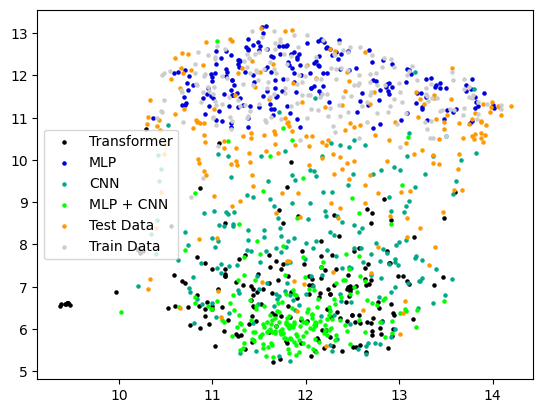

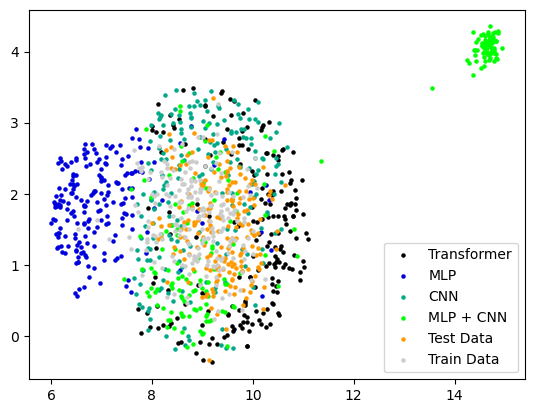

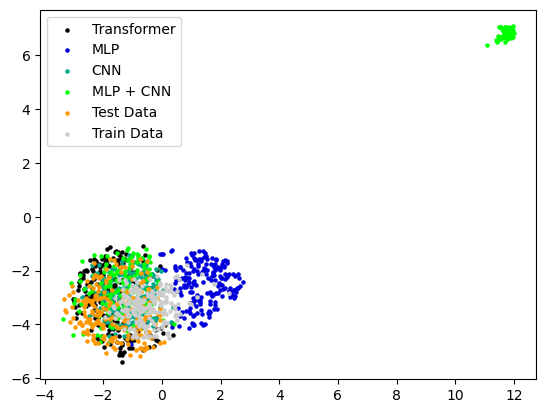

In [ ]:

colors = plt.get_cmap('nipy_spectral')(np.linspace(0, 1, len(datas)))
labels =  ["Transformer", "MLP", "CNN", "MLP + CNN" ,"Test Data", "Train Data"]
for i in range(len(datas)):
    plt_data = embedding[i*num_samples: (i+1)*num_samples]
    plt.scatter(plt_data[:, 0], plt_data[:, 1], color = colors[i], label = labels[i], s = 5)
plt.legend()
plt.savefig("umap_cosine.png")
plt.show()

for i in range(len(datas)):
    plt_data = embedding2[i*num_samples: (i+1)*num_samples]
    plt.scatter(plt_data[:, 0], plt_data[:, 1], color = colors[i], label = labels[i], s = 5)
plt.legend()
plt.show()

for i in range(len(datas)):
    plt_data = embedding3[i*num_samples: (i+1)*num_samples]
    plt.scatter(plt_data[:, 0], plt_data[:, 1], color = colors[i], label = labels[i], s = 5)
plt.legend()
plt.savefig("umap_euclidean.png")
plt.show()

for i in range(len(datas)):
    plt_data = embedding4[i*num_samples: (i+1)*num_samples]
    plt.scatter(plt_data[:, 0], plt_data[:, 1], color = colors[i], label = labels[i], s = 5)
plt.legend()
plt.show()


In [ ]:
num_checks = 200

@torch.compile
def distance(x1, x2):
    x1 = x1.flatten()
    x2 = x2.flatten()
    #return np.arccos(np.dot(x1,x2)/(np.linalg.norm(x1)*np.linalg.norm(x2)))/np.pi
    return np.mean((x1-x2)**2)

def check_diversity_by_closest(data1, data2):

    def find_closest(dataset1, dataset2, num = num_checks):
        all_min_dist = []
        for i,datapoint in enumerate(dataset1):
            if i > num:
                break
            #find closest sample in geneticData
            min_dist = 1e50
            for sample2 in dataset2:
                dist = distance(datapoint, sample2)
                #dist = torch.arccos(torch.nn.functional.cosine_similarity(sample,sample2.flatten(), dim = 0)) / np.pi
                if dist < min_dist and dist > 1e-3:
                    min_dist = dist
            all_min_dist.append(min_dist)
           # print(min_dist)
        
        return all_min_dist

    AA_ts = find_closest(data1, data2)
    AA_st = find_closest(data2, data1)
    AA_tt  = find_closest(data1, data1)
    AA_ss = find_closest(data2, data2)

    AA_truth = 0
    AA_syn = 0
    for i in range(num_checks):
        AA_truth += 1 if AA_ts[i]>AA_tt[i] else 0
        AA_syn += 1 if AA_st[i]>AA_ss[i] else 0
      #  print(AA_ts[i], AA_st[i], AA_tt[i], AA_ss[i])
    
    print(f"AA_truth: {AA_truth/num_checks}, AA_syn: {AA_syn/num_checks} AA_TS {(AA_truth/num_checks + AA_syn/num_checks) /2}")





In [ ]:
from tqdm import tqdm

def distance(x1, x2):
    x1 = x1.flatten()
    x2 = x2.flatten()
    return np.arccos(np.dot(x1,x2)/(np.linalg.norm(x1)*np.linalg.norm(x2)))/np.pi
    return 1-np.dot(x1,x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))
    return np.mean((x1-x2)**2)
  #  return np.mean(np.abs(x1-x2))
def compute_closest(data1,data2, topn = 10):
    closest_neighborss = []
    for i,p1 in tqdm(enumerate(data1)):
        dists = []
        closest_neighbors = []
        for p2 in data2:
            dist = distance(p1, p2)
            closest_neighbors.append(0)
            dists.append(dist)
      #  print(min_dist)
        for a,p1_1 in enumerate(data1):
            dist = distance(p1, p1_1)
            if a == i:
                continue
            closest_neighbors.append(1)
            dists.append(dist)
            # if dist < min_dist and dist > 1e-4:
            #     closest_neighbor = 1
            #     min_dist = dist
        

      #  print(min_dist, closest_neighbor)
        indx = np.argsort(np.array(dists))
        min_dists = np.array(dists)[indx[:topn]]
        closest_neighbors = np.array(closest_neighbors)
        closest_neighbor = closest_neighbors[indx[:topn]]

        print(min_dists)
       # print(closest_neighbor)

        closest_neighborss.append(np.mean(closest_neighbor))
       # print(closest_neighborss)
    closest_neighborss = np.array(closest_neighborss)
    avg_class = np.mean(closest_neighborss)
    return avg_class



In [ ]:

print("Checking diversity for test and train")
print(compute_closest(datas[5], datas[6]))
print("Checking diversity for test and transformer")
print(compute_closest(datas[5], datas[0]))
print("Checking diversity for test and mlp")
print(compute_closest(datas[5], datas[1]))
print("Checking diversity for test and cnn")
print(compute_closest(datas[5], datas[2]))
print("Checking diversity for test and baseline")
print(compute_closest(datas[5], datas[3]))
print("Checking diversity for test and mlp+cnn")
print(compute_closest(datas[5], datas[4]))

print("Checking diversity for mlp and test")
print(compute_closest(datas[1], datas[5]))
print("Checking diversity for transformer and test")
print(compute_closest(datas[0], datas[5]))
print("Checking diversity for cnn and test")
print(compute_closest(datas[2], datas[5]))
print("Checking diversity for baseline and test")
print(compute_closest(datas[3], datas[5]))
print("Checking diversity for mlp+cnn and test")
print(compute_closest(datas[4], datas[5]))
print("Checking diversity for train and test")
print(compute_closest(datas[6], datas[5]))


Checking diversity for test and train


IndexError: list index out of range

In [ ]:

print("Checking diversity for train and transformer")
print(compute_closest(datas[6], datas[0]))
print("Checking diversity for train and mlp")
print(compute_closest(datas[6], datas[1]))
print("Checking diversity for train and cnn")
print(compute_closest(datas[6], datas[2]))
print("Checking diversity for train and baseline")
print(compute_closest(datas[6], datas[3]))
print("Checking diversity for train and mlp+cnn")
print(compute_closest(datas[6], datas[4]))

print("Checking diversity for mlp and train")
print(compute_closest(datas[1], datas[6]))
print("Checking diversity for transformer and train")
print(compute_closest(datas[0], datas[6]))
print("Checking diversity for cnn and train")
print(compute_closest(datas[2], datas[6]))
print("Checking diversity for baseline and train")
print(compute_closest(datas[3], datas[6]))
print("Checking diversity for mlp+cnn and train")
print(compute_closest(datas[4], datas[6]))

In [ ]:
print("nnaa for dataset test and transformer")
check_diversity_by_closest(datas[-1], datas[0])

print("nnaa for dataset test and mlp")
check_diversity_by_closest(datas[-1], datas[1])
print("nnaa for dataset test and cnn")
check_diversity_by_closest(datas[-1], datas[2])
print("nnaa for dataset test and mlp+cnn")
check_diversity_by_closest(datas[-1], datas[3])
print("nnaa for dataset test and train")
check_diversity_by_closest(datas[-1], datas[-2])

nnaa for dataset test and transformer
AA_truth: 0.0, AA_syn: 1.0 AA_TS 0.5
nnaa for dataset test and mlp
AA_truth: 0.0, AA_syn: 1.0 AA_TS 0.5
nnaa for dataset test and cnn
AA_truth: 1.0, AA_syn: 0.02 AA_TS 0.51
nnaa for dataset test and mlp+cnn
AA_truth: 1.0, AA_syn: 0.64 AA_TS 0.8200000000000001
nnaa for dataset test and train
AA_truth: 0.41, AA_syn: 0.705 AA_TS 0.5575


In [ ]:
print("nnaa for dataset train and transformer")
check_diversity_by_closest(datas[-2], datas[0])
print("nnaa for dataset train and mlp")
check_diversity_by_closest(datas[-2], datas[1])
print("nnaa for dataset train and cnn")
check_diversity_by_closest(datas[-2], datas[2])
print("nnaa for dataset train and mlp+cnn")
check_diversity_by_closest(datas[-2], datas[3])

nnaa for dataset train and transformer
AA_truth: 0.0, AA_syn: 1.0 AA_TS 0.5
nnaa for dataset train and mlp
AA_truth: 0.0, AA_syn: 1.0 AA_TS 0.5
nnaa for dataset train and cnn
AA_truth: 1.0, AA_syn: 0.02 AA_TS 0.51
nnaa for dataset train and mlp+cnn
AA_truth: 1.0, AA_syn: 0.635 AA_TS 0.8175
